In [1]:
import pandas as pd
import numpy as np

0.5261341490510434


d:\py\Python3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


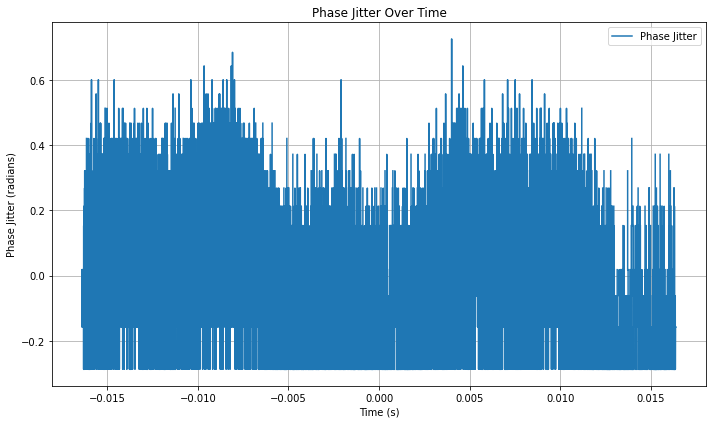

In [2]:
# Re-read the datasets skipping the first two rows
data_0 = pd.read_csv('E://A_my project in Seattle/project/A3_eliminate the phase noise/data_test2/trial1/0.csv')
data0 = data_0.iloc[1:].copy()
data0['Time'] = pd.to_numeric(data0['Time'])
data0['X(CH1)'] = pd.to_numeric(data0['X(CH1)'])

data_0p1 = pd.read_csv('E://A_my project in Seattle/project/A3_eliminate the phase noise/data_test2/trial1/0p1.csv')
data0p1 = data_0p1.iloc[1:].copy()
data0p1['Time'] = pd.to_numeric(data0p1['Time'])
data0p1['X(CH1)'] = pd.to_numeric(data0p1['X(CH1)'])

data_0p2 = pd.read_csv('E://A_my project in Seattle/project/A3_eliminate the phase noise/data_test2/trial1/0p2.csv')
data0p2 = data_0p2.iloc[1:].copy()
data0p2['Time'] = pd.to_numeric(data0p2['Time'])
data0p2['X(CH1)'] = pd.to_numeric(data0p2['X(CH1)'])

# Compute the average values
I_avg = data0['X(CH1)'].mean()
I1 = data0p1['X(CH1)'].mean()
I2 = data0p2['X(CH1)'].mean()

# Calculate the phase using the provided formula
cos_phase = (I_avg - I1 - I2) / np.sqrt(I1 * I2)
phase = np.arccos(cos_phase)

print(phase)

data0['cos_phase_t'] = (data0['X(CH1)'] - I1 - I2) / np.sqrt(I1 * I2)
data0['phase_t'] = np.arccos(data0['cos_phase_t'])

data0['phase_jitter'] = data0['phase_t'] - phase

# Plot the phase jitter over time
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(data0['Time'], data0['phase_jitter'], label='Phase Jitter')
plt.xlabel('Time (s)')
plt.ylabel('Phase Jitter (radians)')
plt.title('Phase Jitter Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


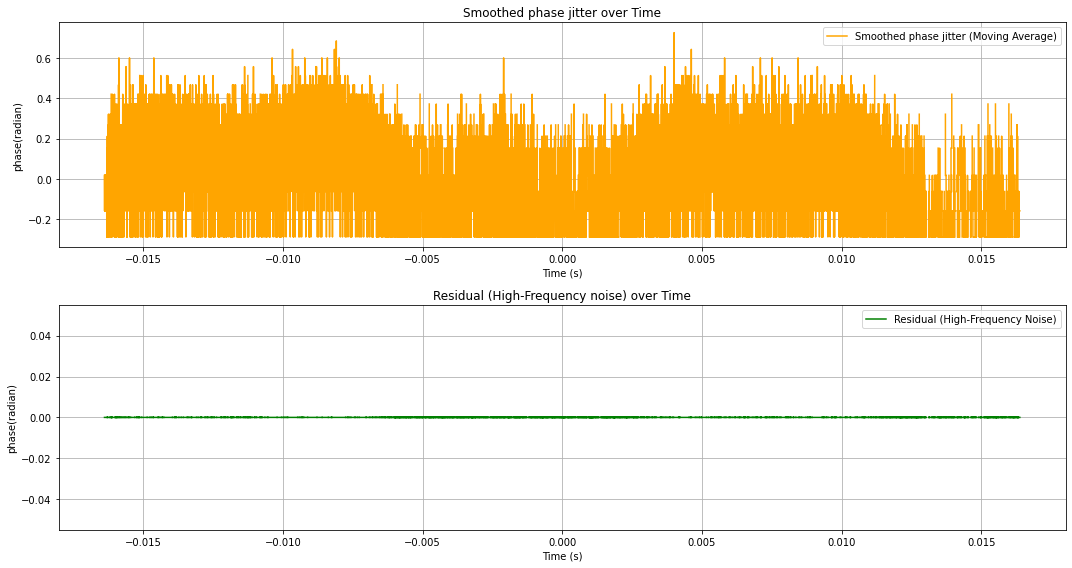

In [3]:
# Apply a moving average to the data
window_size = 1  # Define window size for the moving average
data0['Smoothed'] = data0['phase_jitter'].rolling(window=window_size, center=True).mean()

# Calculate the residual (high-frequency noise)
data0['Residual'] = data0['phase_jitter'] - data0['Smoothed']

# Plot the smoothed signal and residual
plt.figure(figsize=(15, 8))

# Plot the smoothed signal
plt.subplot(2, 1, 1)
plt.plot(data0['Time'], data0['Smoothed'], label='Smoothed phase jitter (Moving Average)', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('phase(radian)')
plt.title('Smoothed phase jitter over Time')
plt.legend()
plt.grid(True)

# Plot the residual
plt.subplot(2, 1, 2)
plt.plot(data0['Time'], data0['Residual'], label='Residual (High-Frequency Noise)', color='green')
plt.xlabel('Time (s)')
plt.ylabel('phase(radian)')
plt.title('Residual (High-Frequency noise) over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

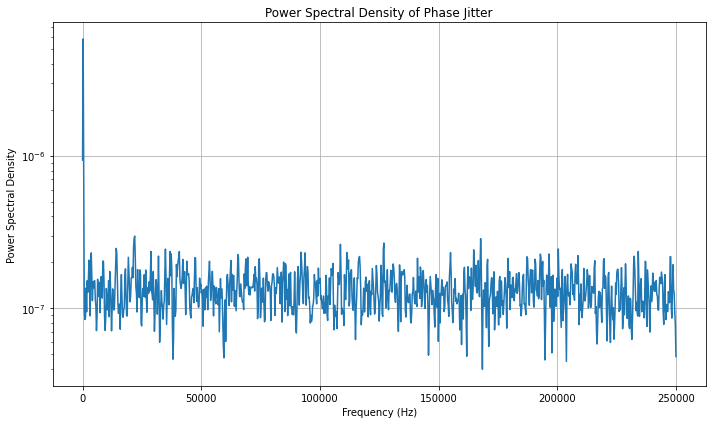

In [4]:
from scipy.signal import welch

# Compute the Power Spectral Density using Welch's method

T = data0['Time'].iloc[1] - data0['Time'].iloc[0]  # sample spacing
frequencies, psd = welch(data0['Smoothed'].dropna(), fs=1.0/T, nperseg=2048)

# Plot the PSD
plt.figure(figsize=(10,6))
plt.semilogy(frequencies, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density of Phase Jitter')
plt.grid(True)
plt.tight_layout()
plt.show()


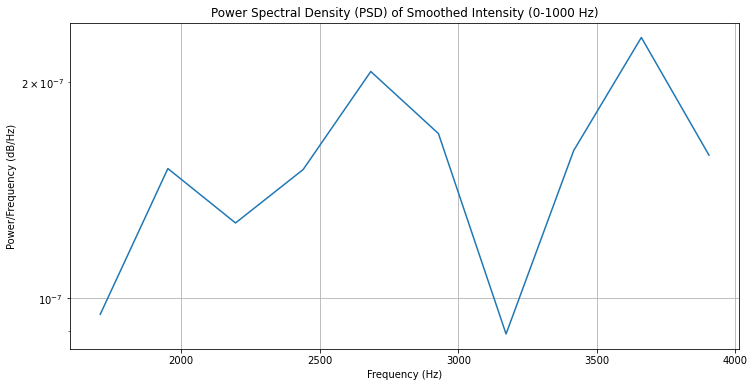

In [5]:
# Filter the data for the specified frequency range (0-1000 Hz)
mask = (frequencies >= 1500) & (frequencies <= 4000)

# Plot the PSD for the specified frequency range
plt.figure(figsize=(12, 6))
plt.semilogy(frequencies[mask], psd[mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density (PSD) of Smoothed Intensity (0-1000 Hz)')
plt.grid(True)
plt.show()


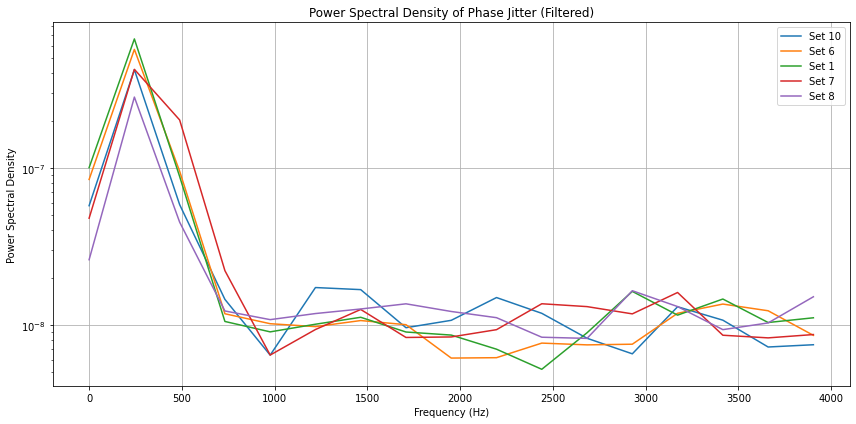

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch,filtfilt, butter

def process_files(prefix: str, base_path='E://A_my project in Seattle/project/A3_eliminate the phase noise/data_test2/trial2/'):
    """
    Process the files with the given prefix and return the frequencies and PSD.
    """
    # Read the datasets
    data_0 = pd.read_csv(f'{base_path}{prefix}.csv')
    data0 = data_0.iloc[1:].copy()
    data0['Time'] = pd.to_numeric(data0['Time'])
    data0['X(CH1)'] = pd.to_numeric(data0['X(CH1)'])

    data_0p1 = pd.read_csv(f'{base_path}{prefix}p1.csv')
    data0p1 = data_0p1.iloc[1:].copy()
    data0p1['Time'] = pd.to_numeric(data0p1['Time'])
    data0p1['X(CH1)'] = pd.to_numeric(data0p1['X(CH1)'])

    data_0p2 = pd.read_csv(f'{base_path}{prefix}p2.csv')
    data0p2 = data_0p2.iloc[1:].copy()
    data0p2['Time'] = pd.to_numeric(data0p2['Time'])
    data0p2['X(CH1)'] = pd.to_numeric(data0p2['X(CH1)'])

    # Compute the average values
    I_avg = data0['X(CH1)'].mean()
    I1 = data0p1['X(CH1)'].mean()
    I2 = data0p2['X(CH1)'].mean()

    # Calculate the phase using the provided formula
    cos_phase = (I_avg - I1 - I2) / (2*np.sqrt(I1 * I2))
    phase = np.arccos(cos_phase)

    data0['cos_phase_t'] = (data0['X(CH1)'] - I1 - I2) / (2*np.sqrt(I1 * I2))
    data0['phase_t'] = np.arccos(data0['cos_phase_t'])
    data0['phase_jitter'] = data0['phase_t'] - phase

    # Apply a moving average to the data
    window_size = 1  # Define window size for the moving average
    data0['Smoothed'] = data0['phase_jitter'].rolling(window=window_size, center=True).mean()

    # Compute the Power Spectral Density using Welch's method
    T = data0['Time'].iloc[1] - data0['Time'].iloc[0]  # sample spacing
    frequencies, psd = welch(data0['Smoothed'].dropna(), fs=1.0/T, nperseg=2048)
    
    return frequencies, psd

# Process each set of files
prefixes = ['10','6', '1','7','8']
results = [process_files(prefix) for prefix in prefixes]

# Plot the filtered PSDs for all sets on the same graph
plt.figure(figsize=(12, 6))
for i, (frequencies, psd) in enumerate(results):
    mask = (frequencies >= 0)  & (frequencies <= 4000)
    plt.semilogy(frequencies[mask], psd[mask], label=f'Set {prefixes[i]}')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density of Phase Jitter (Filtered)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

dominant_frequency_psd = frequencies[mask][np.argmax(psd[mask])]


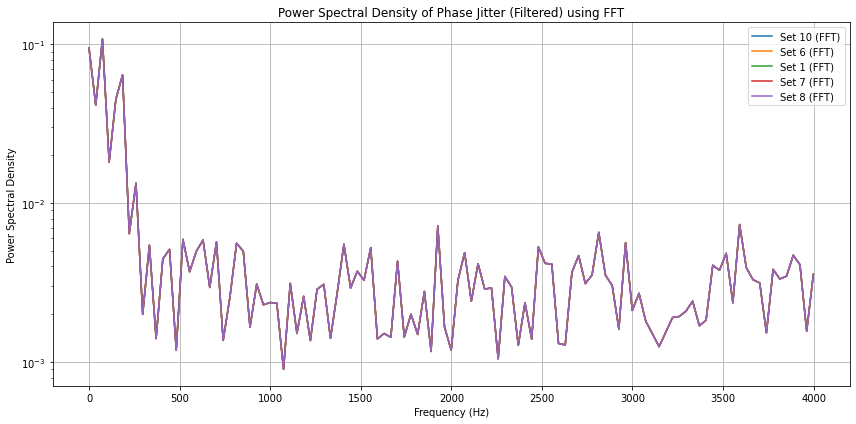

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def process_files_fft(prefix: str, base_path='E://A_my project in Seattle/project/A3_eliminate the phase noise/data_test2/trial2/'):
    # (The same initial part of your code to read and process the data)

    # Compute the FFT
    T = data0['Time'].iloc[1] - data0['Time'].iloc[0]  # sample spacing
    N = len(data0['Smoothed'].dropna())  # Number of data points
    yf = np.fft.fft(data0['Smoothed'].dropna())
    xf = np.fft.fftfreq(N, T)[:N//2]

    # Calculate the PSD using the FFT
    psd_fft = 2.0/N * np.abs(yf[0:N//2])

    return xf, psd_fft

# Process each set of files using FFT
results_fft = [process_files_fft(prefix) for prefix in prefixes]

# Plot the PSDs calculated using FFT for all sets on the same graph
plt.figure(figsize=(12, 6))
for i, (frequencies, psd) in enumerate(results_fft):
    mask = (frequencies >= 0)  & (frequencies <= 4000)
    plt.semilogy(frequencies[mask], psd[mask], label=f'Set {prefixes[i]} (FFT)')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density of Phase Jitter (Filtered) using FFT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# You can also find the dominant frequency as before
dominant_frequency_fft = frequencies[mask][np.argmax(psd[mask])]


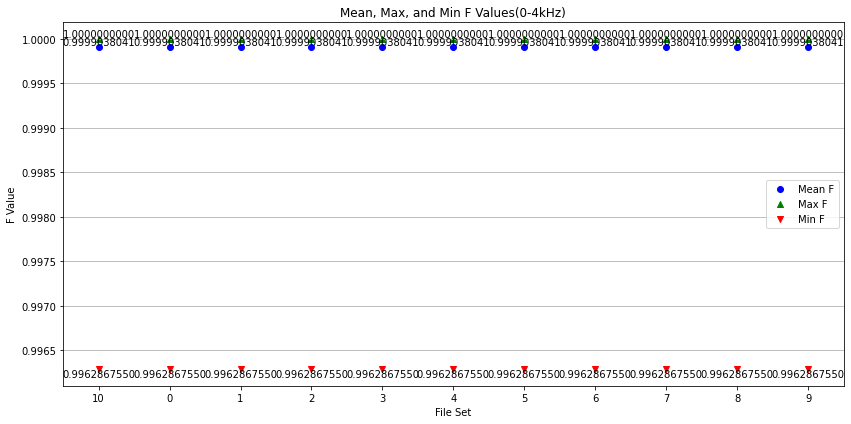

In [9]:
def process_files_for_F(prefix: str, base_path='E://A_my project in Seattle/project/A3_eliminate the phase noise/data_test2/trial2/'):
    """
    Process the files with the given prefix and return the computed value of F.
    """
    # Compute the Power Spectral Density using Welch's method for phase_jitter
    T = data0['Time'].iloc[1] - data0['Time'].iloc[0]  # sample spacing
    frequencies, _ = welch(data0['phase_jitter'].dropna(), fs=1.0/T, nperseg=2048)
    
    # Extract the signal between 1kHz and 4kHz
    nyquist = 0.5 * 1.0/T
    low = 1000 / nyquist
    high = 4000 / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, data0['Smoothed'].dropna())

    # Compute the difference between the maximum and minimum of the filtered signal
    mean_jitter = np.mean(filtered_signal)
    std_jitter = np.std(filtered_signal)
    
    F_values = (1 + np.cos(filtered_signal)) / 2
    
    # Compute the mean and range of F values
    mean_F = np.mean(F_values)
    max_F = np.max(F_values)
    min_F = np.min(F_values)
    
    return mean_F, max_F, min_F

# Process each set of files
prefixes = ['10','0','1','2','3','4','5','6','7','8','9']
results = [process_files_for_F(prefix) for prefix in prefixes]
mean_Fs, max_Fs, min_Fs = zip(*results)

# Plot mean, max, and min F values for each set using a scatter plot
plt.figure(figsize=(12, 6))

# Plotting the mean values
plt.scatter(prefixes, mean_Fs, color='blue', label='Mean F')
for i, value in enumerate(mean_Fs):
    plt.annotate(f"{value:.10f}", (prefixes[i], value), ha='center', va='bottom')

# Plotting the max values
plt.scatter(prefixes, max_Fs, color='green', marker='^', label='Max F')
for i, value in enumerate(max_Fs):
    plt.annotate(f"{value:.10f}", (prefixes[i], value), ha='center', va='bottom')

# Plotting the min values
plt.scatter(prefixes, min_Fs, color='red', marker='v', label='Min F')
for i, value in enumerate(min_Fs):
    plt.annotate(f"{value:.10f}", (prefixes[i], value), ha='center', va='top')

plt.xlabel('File Set')
plt.ylabel('F Value')
plt.title('Mean, Max, and Min F Values(0-4kHz)')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()